In [14]:
%matplotlib inline
import sys
sys.path.append("/media/yifan/Windows/Users/xie/Playground/Numerai/")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import feather
import gc
import paratext
import xgboost as xgb
from IPython.display import display

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC as svc
# from sklearn.svm import LinearSVC as svc
from sklearn.linear_model import SGDClassifier as sgd
from sklearn.cross_validation import train_test_split

from bayes_opt import BayesianOptimization


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
pd.set_option('display.max_seq_items', 200)
pd.set_option('max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
train=pd.read_csv('./data/numerai_training_data.csv')
test=pd.read_csv('./data/numerai_tournament_data.csv')
submit=pd.read_csv('./data/example_predictions.csv')

In [38]:
def log_score(clf, train_data, y, test_data, random_state = 0, print_score=True, calibrated=False, 
          n_folds=5, oof_pred=False):
    if calibrated:
        clf=CalibratedClassifierCV(clf, method='isotonic', cv=5)
    kf = StratifiedKFold(y, n_folds=n_folds, shuffle=True, random_state=random_state)
    oof_train_pred = np.zeros((y.shape[0],2))
    counter=0
    errlist=[]

#     oof_preds=[]
    
    for itrain, itest in kf:
        counter+=1
        Xtr, Xte = train_data[itrain, :], train_data[itest, :]
        ytr, yte = y[itrain], y[itest]
        clf.fit(Xtr, ytr)
        oof_train_pred[itest,:] = clf.predict_proba(Xte)
#         d= clf.decision_function(Xte)[0]
#         probs=np.exp(d)/np.sum(np.exp(d))
#         pred[itest,:] = probs
        err=log_loss(yte, oof_train_pred[itest,:])
        if print_score:
            print("score {} is {:.5f}".format(counter, err, end=' '))
        errlist.append(err)
        
        if oof_pred:
            test_pred=clf.predict_proba(test_data)
            if counter==1:
                oof_test_preds=test_pred/n_folds
            else:
                oof_test_preds=oof_test_preds+test_pred/n_folds
            
    if print_score:
        print("mean score is {:.5f}".format(np.mean(errlist)))
    return log_loss(y, oof_train_pred), oof_train_pred, oof_test_preds

In [39]:
train_target=train['target'].as_matrix()

train_features=train.drop(['target'], axis=1).as_matrix()
test_features=test.drop(['t_id'], axis=1).as_matrix()
train_features=np.sqrt(train_features+3/8)
test_features=np.sqrt(test_features+3/8)

In [40]:
selectP_value=83
ch2=SelectPercentile(chi2, percentile=selectP_value)
select_train=ch2.fit_transform(train_features, train_target)
select_test=ch2.transform(test_features)


rnd_state=np.random.RandomState(1234)
for run in range(0, 1):
    train_i, val_i = train_test_split(np.arange(train_features.shape[0]), train_size = 0.75, 
                                      random_state = rnd_state )
    tr_train_features=train_features[train_i]
    tr_val_features=train_features[val_i]
    y_train=train_target[train_i]
    y_val=train_target[val_i]
    clf=xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=40, objective="binary:logistic",
                         subsample=1, colsample_bytree=0.5, seed=1234)
#     clf=LogisticRegression(C=0.5,solver='liblinear')
    score1, oof_train_preds, oof_test_preds=log_score(clf, tr_train_features, y_train, tr_val_features, 
                                                      random_state=0, n_folds=10, oof_pred=True)

    
    oof_test_score=log_loss(y_val, oof_test_preds)
    
    single_run_pred=clf.fit(tr_train_features, y_train).predict_proba(tr_val_features)
    single_run_score=log_loss(y_val, single_run_pred)
    
    print('oof test score is {:.5f}, single run score is {:.5f}'.format(oof_test_score, single_run_score))


score 1 is 0.69192
score 2 is 0.69179
score 3 is 0.69124
score 4 is 0.69229
score 5 is 0.69236
score 6 is 0.69222
score 7 is 0.69174
score 8 is 0.69189
score 9 is 0.69199
score 10 is 0.69193
mean score is 0.69194
oof test score is 0.69158, single run score is 0.69158


In [44]:
oof_test_preds.shape


(24080, 2)

In [46]:
single_run_pred.shape

(24080, 2)

In [92]:
selectP_value=83
ch2=SelectPercentile(chi2, percentile=selectP_value)
select_train=ch2.fit_transform(train_features, train_target)
select_test=ch2.transform(test_features)



# clf=xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=40, objective="binary:logistic",
#                      subsample=1, colsample_bytree=0.5, seed=1234)
clf=LogisticRegression(C=0.5,solver='liblinear')
score1, oof_train_preds, oof_test_preds=log_score(clf, select_train, train_target, select_test, 
                                                  random_state=0, n_folds=5, oof_pred=True)


score 1 is 0.69129
score 2 is 0.69251
score 3 is 0.69162
score 4 is 0.69113
score 5 is 0.69125
mean score is 0.69156


In [57]:
oof_test_preds.shape

(36066, 2)

In [57]:
single_run_score

0.69130250902271295

In [17]:
start_time=time.time()
# model_type="xgb"
# model=model_spec(model_type)

# scaler=MinMaxScaler().fit(train_features)
# train_features=scaler.transform(train_features)
# test_features=scaler.transform(test_features)

selectP_value=83
ch2=SelectPercentile(chi2, percentile=selectP_value)
select_train=ch2.fit_transform(train_features, train_target)
select_test=ch2.transform(test_features)

# select_train=np.sqrt(select_train+3/8)
# select_test=np.sqrt(select_test+3/8)


clf=LogisticRegression(C=0.5,solver='liblinear')
# clf=sgd(loss='log')
# clf=svc(kernel='linear')
# clf=RidgeClassifier()

# clf=RandomForestClassifier(n_estimators=50)
# clf1=LogisticRegression(C=0.5, multi_class='multinomial',solver='lbfgs')
# clf=BernoulliNB()
# clf=xgb.XGBClassifier()
# clf=xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=40, objective="binary:logistic",
#                      subsample=1, colsample_bytree=0.5, seed=1234)

# clf=xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=50,
#                      subsample=0.8, colsample_bytree=1, seed=1234)



score1, pred1, oof_preds=log_score(clf, select_train, train_target, select_test,calibrated=False, 
                    random_state=0, n_folds=5, oof_pred=True)


score 1 is 0.69129
score 2 is 0.69251
score 3 is 0.69162
score 4 is 0.69113
score 5 is 0.69125
mean score is 0.69156


In [87]:
selectP_value=83
ch2=SelectPercentile(chi2, percentile=selectP_value)
select_train=ch2.fit_transform(train_features, train_target)
select_test=ch2.transform(test_features)

# clf=LogisticRegression(C=0.5,solver='liblinear')
clf=LogisticRegression(C=0.02,solver='lbfgs')
clf.fit(select_train, train_target)
test_pred_proba= clf.predict_proba(select_test)
test_pred_int=clf.predict(select_test)


# clf2=LogisticRegression(C=0.5,solver='liblinear')
# clf2.fit(select_train, train_target)
# test_pred_proba2= clf2.predict_proba(select_test)
# test_pred_int2=clf2.predict(select_test)

# clf3=clf=xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=40, objective="binary:logistic",
#                      subsample=1, colsample_bytree=0.5, seed=1500)
# clf3.fit(select_train, train_target)
# test_pred_proba= clf3.predict_proba(select_test)
# test_pred_int=clf3.predict(select_test)


# test_pred_proba= (test_pred_proba1+test_pred_proba2)/2

In [88]:
submit_pred=submit.copy(deep=True)
submit_pred['probability']=test_pred_proba[:,1]

submit_pred.to_csv('./submit_lg_lbfgs.csv', index=False)

### random seedsx100 xgb

In [90]:
# selectP_value=83
# ch2=SelectPercentile(chi2, percentile=selectP_value)
# select_train=ch2.fit_transform(train_features, train_target)
# select_test=ch2.transform(test_features)

# clf=LogisticRegression(C=0.5,solver='liblinear')
# clf=LogisticRegression(C=0.02,solver='lbfgs')
# clf.fit(select_train, train_target)
# test_pred_proba1= clf.predict_proba(select_test)
# test_pred_int1=clf.predict(select_test)


# clf2=LogisticRegression(C=0.5,solver='liblinear')
# clf2.fit(select_train, train_target)
# test_pred_proba2= clf2.predict_proba(select_test)
# test_pred_int2=clf2.predict(select_test)

for n in range(1000,1100):
    
    if n%20==0: print(n)
    clf=xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=40, objective="binary:logistic",
                         subsample=1, colsample_bytree=0.5, seed=n)
    clf.fit(select_train, train_target)
    test_pred_proba= clf.predict_proba(select_test)

    if n==1000:
        total=test_pred_proba/100
    else:
        total=total+test_pred_proba/100
    # test_pred_int=clf3.predict(select_test)


# test_pred_proba= (test_pred_proba1+test_pred_proba2)/2

1000
1020
1040
1060
1080


In [91]:
submit_pred=submit.copy(deep=True)
submit_pred['probability']=total[:,1]

submit_pred.to_csv('./submit_xgb_total100_nose.csv', index=False)

In [89]:
submit_pred=submit.copy(deep=True)
submit_pred['probability']=(total[:,1]+test_pred_proba[:,1])/2

submit_pred.to_csv('./submit_xgb_lg２.csv', index=False)

In [72]:
for n in range(0,3):
    print(n)

0
1
2


In [67]:
test_pred_proba

array([[ 0.50843602,  0.49156398],
       [ 0.50927103,  0.490729  ],
       [ 0.47004002,  0.52995998],
       ..., 
       [ 0.50848806,  0.49151191],
       [ 0.47891986,  0.52108014],
       [ 0.4901318 ,  0.5098682 ]], dtype=float32)

In [59]:
# oof_preds[0:10]
submit_pred=submit.copy(deep=True)
submit_pred['probability']=oof_test_preds[:,1]

submit_pred.to_csv('./submit_temp.csv', index=False)


In [51]:
test_pred_proba

array([[ 0.4933762 ,  0.5066238 ],
       [ 0.5084219 ,  0.49157813],
       [ 0.46304178,  0.53695822],
       ..., 
       [ 0.50387979,  0.49612021],
       [ 0.48813456,  0.51186544],
       [ 0.48749042,  0.51250958]], dtype=float32)

In [58]:
oof_test_preds

array([[ 0.50247519,  0.49752481],
       [ 0.51532089,  0.48467911],
       [ 0.44468836,  0.55531164],
       ..., 
       [ 0.48737829,  0.51262171],
       [ 0.45682258,  0.54317742],
       [ 0.48258946,  0.51741054]])

In [30]:
test_pred_proba2

array([[ 0.50102102,  0.49897898],
       [ 0.51135697,  0.48864303],
       [ 0.45088753,  0.54911247],
       ..., 
       [ 0.49144889,  0.50855111],
       [ 0.46244257,  0.53755743],
       [ 0.47874819,  0.52125181]])

In [217]:
submit_pred=submit.copy(deep=True)
submit_pred['probability']=test_pred_proba[:,1]

submit_pred.to_csv('./submit_selectP83_anscombe.csv', index=False)

In [218]:
submit_pred.head(5)

,t_id,probability
0,7726,0.499
1,15876,0.489
2,22137,0.549
3,22770,0.483
4,33025,0.483


/home/yifan/playground/anaconda3/envs/snakes/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:407: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  kept_ties = ties[:max_feats - mask.sum()]


Score for 50.00 is 0.691698 
Score for 55.56 is 0.691659 
Score for 61.11 is 0.691624 
Score for 66.67 is 0.691627 
Score for 72.22 is 0.691623 
Score for 77.78 is 0.691593 
Score for 83.33 is 0.691572 
Score for 88.89 is 0.691579 
Score for 94.44 is 0.691582 
Score for 100.00 is 0.691590 


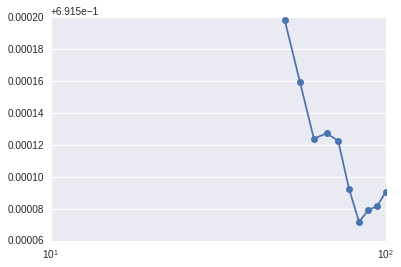

In [172]:
Ps = np.linspace(50, 100, num=10)
res=[]
for P in Ps:
    selectP_value=P
    ch2=SelectPercentile(chi2, percentile=selectP_value)
    select_train=ch2.fit_transform(train_features, train_target)
    select_test=ch2.transform(test_features)
    err=score(LogisticRegression(C=0.02,solver='lbfgs'), select_train, train_target, print_score=False)[0]
    print("Score for %.2f is %.6f " %(P, err))
    res.append(err)

plt.semilogx(Ps, res,'-o');